In [1]:
from datetime import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Read input data

             Source      time  year  month         CO2   CO2_trend
0     Joos & Spahni  1750.042  1750      1  278.616087  277.766770
1     Joos & Spahni  1750.125  1750      2  278.928941  277.763822
2     Joos & Spahni  1750.208  1750      3  279.222544  277.760877
3     Joos & Spahni  1750.292  1750      4  279.480197  277.757935
4     Joos & Spahni  1750.375  1750      5  279.354402  277.754997
...             ...       ...   ...    ...         ...         ...
3284           NOAA  2023.708  2023      9  417.050000  419.880000
3285           NOAA  2023.792  2023     10  418.740000  420.240000
3286           NOAA  2023.875  2023     11  420.360000  420.500000
3287           NOAA  2023.958  2023     12  421.570000  420.910000
3288           NOAA  2024.042  2024      1  422.160000  421.090000

[3289 rows x 6 columns]


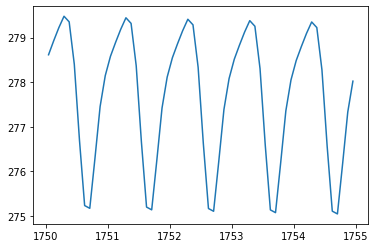

In [2]:
path_in = "Atm_CO2_forcing.csv"

data_in = pd.read_table(
    path_in,
    skiprows=21,
    skipinitialspace=True,
    sep=",",
    names=["Source", "time", "year", "month", "CO2", "CO2_trend"]
)

print(data_in)

plt.plot(data_in["time"][:60], data_in["CO2"][:60]);
plt.show()

# Create xarray Dataset from input data

In [3]:
t_vals = (data_in["time"] - 1700.0) * 365.0
time = xr.DataArray(
    data=t_vals,
    coords={"time": t_vals},
    attrs={"long_name": "time", "units": "days since 1700-01-01", "calendar": "noleap"},
)
print(time)

lat_val = [0.0]
lat = xr.DataArray(
    data=lat_val, coords={"lat": lat_val}, attrs={"long_name": "latitude", "units": "degrees_north"}
)

lon_val = [180.0]
lon = xr.DataArray(
    data=lon_val, coords={"lon": lon_val}, attrs={"long_name": "longitude", "units": "degrees_east"}
)

<xarray.DataArray 'time' (time: 3289)>
array([ 18265.33 ,  18295.625,  18325.92 , ..., 118214.375, 118244.67 ,
       118275.33 ])
Coordinates:
  * time     (time) float64 1.827e+04 1.83e+04 1.833e+04 ... 1.182e+05 1.183e+05
Attributes:
    long_name:  time
    units:      days since 1700-01-01
    calendar:   noleap


In [4]:
area = xr.DataArray(
    data=[[4.0*math.pi]],
    coords={"lat": lat, "lon": lon},
    attrs={"long_name": "grid cell area", "units": "radians^2"},
)

mask = xr.DataArray(
    data=[[1.0]],
    coords={"lat": lat, "lon": lon},
    attrs={"long_name": "Mask of active cells: 1=active", "units": "unitless"},
)

CO2 = xr.DataArray(
    data=np.expand_dims(data_in["CO2"].values, (-2, -1)),
    coords={"time": time, "lat": lat, "lon": lon},
    attrs={"long_name": "atmospheric CO2 concentration", "units": "ppmv"},
)

CO2_trend = xr.DataArray(
    data=np.expand_dims(data_in["CO2_trend"].values, (-2, -1)),
    coords={"time": time, "lat": lat, "lon": lon},
    attrs={"long_name": "atmospheric CO2 concentration", "units": "ppmv"},
)

In [5]:
ds = xr.Dataset(
    data_vars={"time": time, "area": area, "mask": mask, "CO2": CO2, "CO2_trend": CO2_trend}
)
ds.attrs["input_file_list"] = path_in
ds.attrs["date_created"] = f"{datetime.now()}"
ds.encoding["unlimited_dims"] = "time"
print(ds)

<xarray.Dataset>
Dimensions:    (time: 3289, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 1.827e+04 1.83e+04 ... 1.182e+05 1.183e+05
  * lat        (lat) float64 0.0
  * lon        (lon) float64 180.0
Data variables:
    area       (lat, lon) float64 12.57
    mask       (lat, lon) float64 1.0
    CO2        (time, lat, lon) float64 278.6 278.9 279.2 ... 420.4 421.6 422.2
    CO2_trend  (time, lat, lon) float64 277.8 277.8 277.8 ... 420.5 420.9 421.1
Attributes:
    input_file_list:  Atm_CO2_forcing.csv
    date_created:     2024-06-19 13:05:24.290855


# Write Dataset to netCDF file

In [6]:
for d in [ds.data_vars, ds.coords]:
    for varname in d:
        if "_FillValue" not in d[varname].encoding:
            d[varname].encoding["_FillValue"] = None

In [7]:
datestamp = datetime.now().strftime("%Y%m%d")
path_out = f"fco2_datm_global_GCB_2024_1750-2023_c{datestamp}.nc"
print(f"creating {path_out}")
ds.to_netcdf(path_out)

creating fco2_datm_global_GCB_2024_1750-2023_c20240619.nc


# Confirm that netCDF file can be read back in

In [8]:
ds2 = xr.open_dataset(path_out)
print(ds2)

<xarray.Dataset>
Dimensions:    (time: 3289, lat: 1, lon: 1)
Coordinates:
  * time       (time) object 1750-01-16 07:55:11.999997 ... 2024-01-16 07:55:...
  * lat        (lat) float64 0.0
  * lon        (lon) float64 180.0
Data variables:
    area       (lat, lon) float64 ...
    mask       (lat, lon) float64 ...
    CO2        (time, lat, lon) float64 ...
    CO2_trend  (time, lat, lon) float64 ...
Attributes:
    input_file_list:  Atm_CO2_forcing.csv
    date_created:     2024-06-19 13:05:24.290855
